# Recovery of gold from ore

We need to prepare a prototype of a machine learning model for the company. The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold-bearing ore. The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

As data, we are provided with data with the parameters of extraction and purification.

We need to:

1. Prepare data;
2. Make data analysis;
3. Create and train model.

To make this project use libraries *pandas*, *matplotlib* и *sklearn.* 

## Data preparation

Import the necessary libraries:

In [1]:
#tables:
import pandas as pd

In [2]:
#graphics:
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
#statistics:
import numpy as np

In [4]:
#ML:
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

### Open data and study it:

In [5]:
train_df = pd.read_csv("/Users/a1/Desktop/data_folder/gold_recovery_data/gold_recovery_train_new.csv")
test_df = pd.read_csv("/Users/a1/Desktop/data_folder/gold_recovery_data/gold_recovery_test_new.csv")
full_df = pd.read_csv("/Users/a1/Desktop/data_folder/gold_recovery_data/gold_recovery_full_new.csv")

In [6]:
def get_info(df):
    print('Shape:', df.shape)
    print('Full duplicates:',df.duplicated().sum())
    print(df.info())

In [7]:
get_info(train_df)

Shape: (14149, 87)
Full duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                 

In [8]:
get_info(test_df)

Shape: (5290, 53)
Full duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290

In [9]:
get_info(full_df)

Shape: (19439, 87)
Full duplicates: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                 

The first study with data showed that:

* the maximum number of columns is 87, hence the test_df has the smallest possible number of columns (53 out of 87);

* all dataframes do not contain complete duplicates;

* there are gaps in each of the dataframes, at first glance their number is insignificant (we will check this later);

* each dataframe has date column, which format is object.

### Let's check that the enrichment efficiency is calculated correctly

Calculation formula:
recovery = C*(F-T) / F*(C-T) * 100

Let's calculate it on the training sample for the attribute *rougher.output.recovery.* Let's find MAE between our calculations and the value of the attribute.

In [10]:
def get_recovery (df):
    recovery = (df['rougher.output.concentrate_au'] *(df['rougher.input.feed_au'] - df['rougher.output.tail_au'])) / (df['rougher.input.feed_au']*(df['rougher.output.concentrate_au'] - df['rougher.output.tail_au'])) * 100
    return recovery

In [11]:
#let's prepare a training sample for the use of the get_recovery function, remove the existing gaps:
train_df_clean = train_df.dropna(axis = 0) 

In [12]:
y_test = train_df_clean.apply(get_recovery,axis = 1)

In [13]:
train_df_clean['rougher.output.recovery'].describe()

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [14]:
mae = mean_absolute_error(y_test, train_df_clean['rougher.output.recovery'])
mae

9.82970122149377e-15

We got MAE = 9.8, which is less than std=13.59. Therefore, we can assume that the enrichment efficiency is calculated correctly.

### Let's analyze the features that are not available in the test sample:

In [15]:
missing_test_features = list(set(train_df.columns) - set(test_df.columns))
missing_test_features

['secondary_cleaner.output.tail_ag',
 'rougher.output.tail_sol',
 'secondary_cleaner.output.tail_sol',
 'rougher.output.tail_pb',
 'rougher.output.concentrate_au',
 'final.output.concentrate_au',
 'final.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_pb',
 'rougher.output.recovery',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_ag',
 'final.output.concentrate_sol',
 'primary_cleaner.output.concentrate_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'primary_cleaner.output.tail_sol',
 'rougher.output.concentrate_sol',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'rougher.output.tail_ag',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'final.output.recovery',
 'rougher.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'rougher.calculation.sulfate_to_au_concentrate',
 'final.output.concentrate_ag',
 'primary_cleaner.output.tail_pb',
 'rougher.

In [16]:
print('Number of missing features:',len(missing_test_features))

Number of missing features: 34


In [17]:
sorted_missing_test_features = sorted(missing_test_features)

In [18]:
sorted_missing_test_features

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The test_df table is missing 34 features that are in full_df, among which:

* there are no features containing raw material parameters(input);

* there are no features characterizing the parameters of raw materials (state);

* 4 features refer to calculated signs (calculation);

* 2 features we coulf relate to target ones  -  *'final.output.recovery'* и *'rougher.output.recovery'*;

* overall, the missing features relate to and describe the stages of the production process, that is, they contain data that are filled gradually, and not initially.

### Carry out data preprocessing:

Let's add data about target features to the test sample:

In [19]:
test_df = test_df.merge(full_df[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

Remove unnecessary features from the training sample:

In [20]:
train_df = train_df[test_df.columns]

In [21]:
test_df.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [23]:
test_df.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   primary_cleaner.input.sulfate               14129 non-null  float64
 2   primary_cleaner.input.depressant            14117 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14049 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14145 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14148 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14145 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14148 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      14147 non-null  float64
 10  primary_cl

In [25]:
train_df.isna().sum()

date                                            0
primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29


Since the number of omissions is insignificant in each df, we will delete the missing values:

In [26]:
test_df = test_df.dropna()
train_df = train_df.dropna()

In [27]:
test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [28]:
test_df.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


In [29]:
train_df.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016


In [30]:
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%dT%H:%M:%S')
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y-%m-%dT%H:%M:%S')

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5229 entries, 0 to 5228
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5229 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5229 non-null   float64       
 2   primary_cleaner.input.depressant            5229 non-null   float64       
 3   primary_cleaner.input.feed_size             5229 non-null   float64       
 4   primary_cleaner.input.xanthate              5229 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64       
 9   primary_

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12679 entries, 0 to 12678
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        12679 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               12679 non-null  float64       
 2   primary_cleaner.input.depressant            12679 non-null  float64       
 3   primary_cleaner.input.feed_size             12679 non-null  float64       
 4   primary_cleaner.input.xanthate              12679 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      12679 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    12679 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      12679 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    12679 non-null  float64       
 9   primar

In the process of preparing data for analysis:

* the calculation of the enrichment efficiency was verified - it turned out to be correct;

* the features in the train and test samples were evaluated - targets were added to the test sample, and extra features were removed from the training sample;

* omissions were processed, the format of the values of the date column was adjusted to the correct one.

## Data analysis:

### Let's study how the concentration of metals (Au, Ag, Pb) changes at various stages of purification.

* Au - gold;

* Ag - silver;

* Pb - lead.

Possible values for the block[stage]:
* rougher 
* primary_cleaner 
* secondary_cleaner 
* final

Let's study full_df:

In [33]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [34]:
metals = ['au', 'ag', 'pb']

In [35]:
# columns with metalls:
metals_columns = []
for col in list(full_df.columns):
    for Me in metals:
        if Me in col.split('_'):
            metals_columns.append(col)

metals_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au']

In [36]:
del metals_columns[3:6]
metals_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au']

In [37]:
del metals_columns[6:16]
metals_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au']

In [38]:
del metals_columns[9:]
metals_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

In [39]:
met_col_con = metals_columns
met_col_con

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

In [40]:
au, ag, pb = [list(filter(lambda col: m in col, met_col_con))[::-1] for m in metals]

In [41]:
stages = sorted(list(set([col[:col.index('.')] for col in met_col_con])), reverse=True)
stages

['rougher', 'primary_cleaner', 'final']

In [42]:
mconc_df = pd.DataFrame(zip(au, ag, pb), index=stages, columns=metals).applymap(lambda x: full_df[x].mean())
mconc_df

,au,ag,pb
rougher,19.772000,11.994759,7.606272
primary_cleaner,32.119400,8.442408,9.829530
final,44.076513,5.168470,9.978895


During processing, the concentration of gold and lead increases, and silver decreases.

### Let's compare the size distributions of raw material feeds in the training and test samples.
If the distributions are very different from each other, the model estimate will be incorrect.

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12679 entries, 0 to 12678
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        12679 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               12679 non-null  float64       
 2   primary_cleaner.input.depressant            12679 non-null  float64       
 3   primary_cleaner.input.feed_size             12679 non-null  float64       
 4   primary_cleaner.input.xanthate              12679 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      12679 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    12679 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      12679 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    12679 non-null  float64       
 9   primar

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


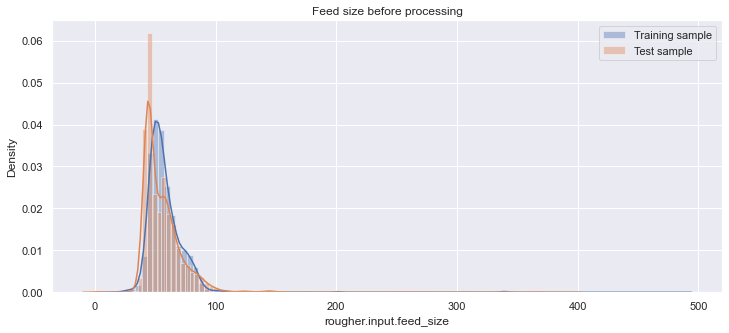

In [44]:
sb.set(rc={'figure.figsize':(12,5)})
sb.distplot(train_df['rougher.input.feed_size'], bins=100, hist = True, kde = True, label='Training sample')
sb.distplot(test_df['rougher.input.feed_size'], bins=100, hist = True, kde = True, label='Test sample')
plt.legend()
plt.title('Feed size before processing')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


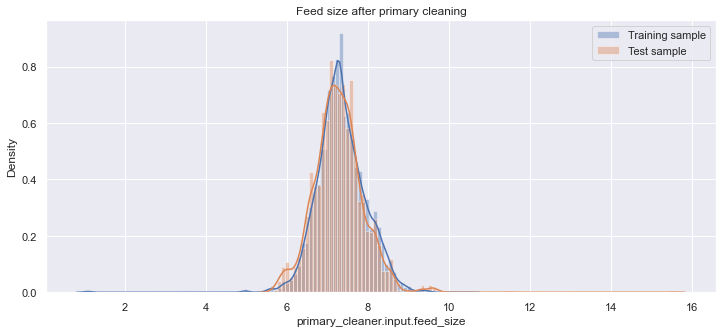

In [45]:
sb.set(rc={'figure.figsize':(12,5)})
sb.distplot(train_df['primary_cleaner.input.feed_size'], bins=100,hist = True, kde=True, label='Training sample')
sb.distplot(test_df['primary_cleaner.input.feed_size'], bins=100, hist = True, kde=True, label='Test sample')
plt.legend()
plt.title('Feed size after primary cleaning')
plt.show()

The distribution of features on both graphs is normal and coincides with each other on the training and test samples.

### Study the total concentration of all substances at different stages: in raw materials, in rough and final concentrates:

Let 's determine which features belong to the stages: raw materials, raw materials and final concentrate.

In [46]:
rougher_input_stage = ['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher_output_stage = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
final_stage = ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

In [47]:
result_cols = rougher_input_stage, rougher_output_stage, final_stage
result_cols

(['rougher.input.feed_ag',
  'rougher.input.feed_au',
  'rougher.input.feed_pb',
  'rougher.input.feed_sol'],
 ['rougher.output.concentrate_ag',
  'rougher.output.concentrate_au',
  'rougher.output.concentrate_pb',
  'rougher.output.concentrate_sol'],
 ['final.output.concentrate_ag',
  'final.output.concentrate_au',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol'])

In [48]:
# use the zip iterator through the for loop
for cols, result in zip(result_cols,
                        ['rougher_input_stage', 'rougher_output_stage', 'final_stage']):
    # Setting the value for the entire column = the sum of the corresponding columns
    full_df.loc[:, result] = sum(full_df[col] for col in cols)

In [49]:
total_conc = full_df.iloc[:, -3:]
total_conc.head()

,rougher_input_stage,rougher_output_stage,final_stage
0,51.680034,66.424950,63.644396
1,50.659114,67.012710,63.957723
2,50.609929,66.103793,64.311180
3,51.061546,65.752751,63.573449
4,47.859163,65.908382,64.004667


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

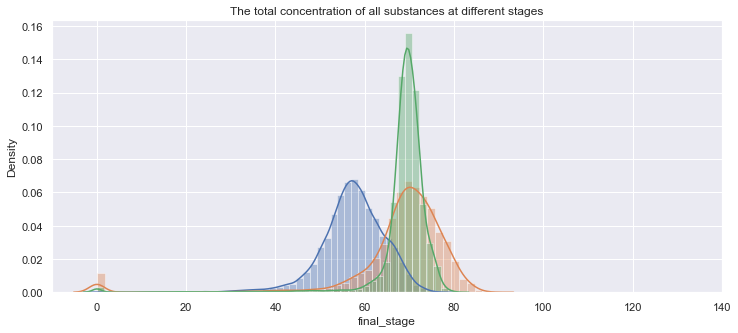

In [50]:
for col, l in zip(total_conc.columns,['Raw material', 'Rough concentrate', 'Final concentrate']):
    sb.distplot(total_conc[col], label=l)
    plt.xlim(-10, 140)
    plt.title('The total concentration of all substances at different stages')

The graph shows that there are outliers in the total sample, this may indicate the presence of incorrect values in the test and training samples. Therefore, we need to process these outliers and, if possible, eliminate the corresponding data from the test and training samples so that this does not affect the quality of the model.

In [51]:
total_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rougher_input_stage   19245 non-null  float64
 1   rougher_output_stage  19416 non-null  float64
 2   final_stage           19227 non-null  float64
dtypes: float64(3)
memory usage: 455.7 KB


In [52]:
total_conc.describe()

,rougher_input_stage,rougher_output_stage,final_stage
count,19245.000000,19416.000000,19227.000000
mean,57.407926,68.188914,68.727562
std,7.165219,12.478522,7.423741
min,0.040000,0.000000,0.000000
25%,53.660745,66.026048,67.985659
50%,57.647093,70.186130,69.632597
75%,62.012223,74.362878,71.390461
max,76.978947,88.140119,80.210644


In [53]:
clean_total_conc = total_conc.query('rougher_input_stage > 10')
clean_total_conc = clean_total_conc.query('rougher_output_stage > 10')
clean_total_conc = clean_total_conc.query('final_stage > 10')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

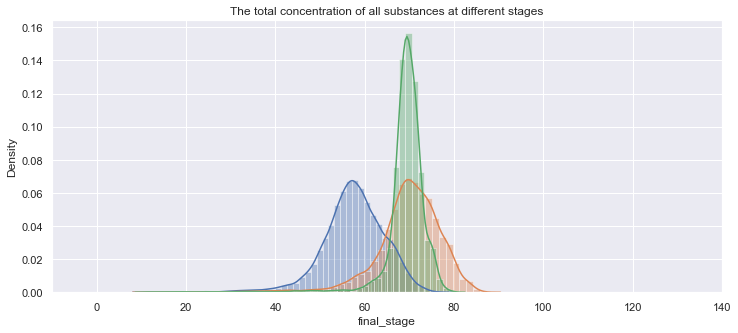

In [54]:
for col, l in zip(clean_total_conc.columns,['Raw material', 'Rough concentrate', 'Final concentrate']):
    sb.distplot(clean_total_conc[col], label=l)
    plt.xlim(-10, 140)
    plt.title('The total concentration of all substances at different stages')

In [55]:
# Let's remove data with anomalies from the training sample
train_clean = train_df[train_df.index.isin(clean_total_conc.index)]
# Let's remove data with anomalies from the test sample
test_clean = test_df[test_df.index.isin(clean_total_conc.index)]

In [56]:
train_clean.shape

(12067, 55)

In [57]:
test_clean.shape

(4864, 55)

As a result of data analysis:

* the change in the concentration of metals during processing was studied, which confirmed its expediency and the adequacy of the data;

* some metrics (the size of feeds of raw materials) in the test and training samples are considered - the distribution of the feature showed that the data are adequate in both samples and normally distributed;

* the total concentration of metals at key processing stages was studied, which allowed to establish a number of anomalies that were successfully eliminated from the training and test samples.

## Model

### Let's create a function to calculate the final sMAPE.

In [58]:
def smape(y_true, y_pred):
    smape = np.mean(abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2))*100
    return smape

In [59]:
def total_smape(smape_rougher, smape_final):
    total_smape = 0.25*smape_rougher + 0.75*smape_final
    return total_smape

In [60]:
smape_score = make_scorer(smape, greater_is_better=False)

### Model training

Let's highlight the target indicators in the training and test samples:

In [61]:
# train_df 
features_train = train_df.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = train_df['rougher.output.recovery']
target_train_final = train_df['final.output.recovery']

# test_df
features_test = test_df.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = test_df['rougher.output.recovery']
target_test_final = test_df['final.output.recovery']

Let's create a hyperparameter iteration function that will be useful for models DecisionTreeRegressor and RandomForestRegressor:

#### Linear regression:

In [62]:
smape_rougher = np.mean(cross_val_score(LinearRegression(), features_train, 
                                        target_train_rougher, scoring=smape_score, 
                                        cv=5, n_jobs=-1))
smape_final = np.mean(cross_val_score(LinearRegression(), features_train, 
                                      target_train_final, scoring=smape_score, 
                                      cv=5, n_jobs=-1))
print('Total SMAPE:',total_smape(smape_rougher, smape_final))

Total SMAPE: -10.932332228426176


#### DecisionTreeRegressor:

In [63]:
def get_params(model, params, features, target, score=smape_score):
    grid = GridSearchCV(model(random_state=12345), params, scoring=score, cv=5)
    grid.fit(features, target)
    print('best parameter: {}'.format(grid.best_params_))

In [64]:
tree_params = {
    'max_depth': range(1,11),
    'min_samples_leaf': range(1,11),
    'min_samples_split': range(2,11)
}

print('target feature: rougher.output.recovery')
get_params(DecisionTreeRegressor, tree_params, features_train, target_train_rougher)
print('target feature: final.output.recovery')
get_params(DecisionTreeRegressor, tree_params, features_train, target_train_final)

target feature: rougher.output.recovery
best parameter: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
target feature: final.output.recovery
best parameter: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [65]:
smape_rougher = np.mean(cross_val_score(DecisionTreeRegressor(max_depth=5, min_samples_leaf=10,
                                                              min_samples_split=2, random_state=12345), 
                                        features_train, target_train_rougher, scoring=smape_score, 
                                        cv=5))
smape_final = np.mean(cross_val_score(DecisionTreeRegressor(max_depth=1, min_samples_leaf=1,
                                                            min_samples_split=2, random_state=12345), 
                                      features_train, target_train_final, scoring=smape_score,
                                      cv=5))
print(smape_rougher, smape_final)
print('Итоговый SMAPE:', total_smape(smape_rougher, smape_final))

-10.631417288168036 -9.726824440809125
Итоговый SMAPE: -9.952972652648853


#### RandomForestRegressor:

In [66]:
forest_params = {
    'n_estimators': np.arange(11, 51, 10),
    'max_depth': np.arange(1, 11),
}

print('target feature: rougher.output.recovery')
get_params(RandomForestRegressor, forest_params, features_train, target_train_rougher)
print('target feature: final.output.recovery')
get_params(RandomForestRegressor, forest_params, features_train, target_train_final)

target feature: rougher.output.recovery
best parameter: {'max_depth': 5, 'n_estimators': 31}
target feature: final.output.recovery
best parameter: {'max_depth': 5, 'n_estimators': 11}


In [67]:
smape_rougher = np.mean(cross_val_score(RandomForestRegressor(max_depth=5, n_estimators=31, random_state=12345), 
                                        features_train, target_train_rougher, scoring=smape_score, cv=5))
smape_final = np.mean(cross_val_score(RandomForestRegressor(max_depth=5, n_estimators=11, random_state=12345), 
                                      features_train, target_train_final, scoring=smape_score, cv=5))
print(smape_rougher, smape_final)
print('Total SMAPE:', total_smape(smape_rougher, smape_final))

-10.352734658716338 -9.38298685929323
Total SMAPE: -9.625423809149007


The best result showed by model RandomForestRegressor. Check its value on test sample.

In [68]:
model = RandomForestRegressor(max_depth=5, n_estimators=31, random_state=12345)
model.fit(features_train, target_train_rougher)
predicted = model.predict(features_test)
smape_rought = smape(target_test_rougher, predicted)

model = RandomForestRegressor(max_depth=5, n_estimators=11, random_state=12345)
model.fit(features_train, target_train_final)
predicted = model.predict(features_test)
smape_final = smape(target_test_final, predicted)

print('Total sMAPE:', total_smape(smape_rougher, smape_final))

Total sMAPE: 4.563804630016177


Let's compare its values with the results of the constant model DummyRergressor:

In [69]:
m_dummy_rougher = DummyRegressor(strategy="median")
m_dummy_final = DummyRegressor(strategy="median")

m_dummy_rougher.fit(features_train, target_train_rougher)
m_dummy_final.fit(features_train, target_train_final)

m_dummy_rougher_predicted = m_dummy_rougher.predict(features_test)
m_dummy_final_predicted = m_dummy_final.predict(features_test)

dummy_smape_roughter = smape(target_test_rougher, m_dummy_rougher_predicted)
dummy_smape_final = smape(target_test_final, m_dummy_final_predicted)

print('Total SMAPE:', total_smape(dummy_smape_roughter, dummy_smape_final))

Total SMAPE: 9.079458241653274


Thus, since the SMAPE of the constant model is higher than the SMAPE of the RandomForestRegressor model, we can conclude that the values of the RandomForestRegressor model are adequate and usable.

## Conclusion:

In the process of working on this project:

* data for training and model building were studied and prepared (the calculation of the enrichment efficiency was verified, the features in the train and test samples were evaluated - targets were added to the test sample, and extra features were removed from the training sample, omissions were processed, the format of the date column values was adjusted correctly);

* the data were analyzed for their adequacy, which made it possible to adjust test and training samples for the correct training of models;

* three regression models were trained and tested, of which the RandomForestRegressor model with the final result showed the best result SMAPE 4.563804630016169.